# ICDAR 2024 SAM Track 1
This notebook focuses on Task 1: Few-Shot Layout Segmentation, involving the model's prediction of pixel-level segmentation results for ancient manuscript images.

1. Team Name for the Competition: CNKI Large Model and Future Technology R&D Department
2. Participant Names: Xiaofei Lu, Haishan Wang, Jing Chen, Yanhong Bi, Zongyue Li, Zixuan Huang.
3. Tracks Participating In: Our team will be participating in Track 1 and Track 2.

Let me know if you have any concern, please contact me via winstonli711@gmail.com
or byh11630@cnki.net

In [ ]:
# @title Install packages
!pip install timm==0.5.4
!pip install Pillow
!pip install blobfile
!pip install mypy
!pip install numpy
!pip install pytest
!pip install requests
!pip install einops
# !pip install tensorboardX
# !pip install deepspeed==0.4.0
!pip install scipy
!pip install iopath
!pip install fvcore
# !pip install opencv-python

Import packages

In [4]:
import os
import sys
import argparse
import re
import cv2
from PIL import Image
import numpy as np
import torch
import shutil
from matplotlib import pyplot as plt

In [ ]:
# if it report some errors, just ignore it
# @title Install dependencies of Detectron2
# install dependencies: (use cu101 because colab has CUDA 10.1)
#!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab


In [ ]:
#@title Install detectron2
%cd /content/
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
# !pip install -r requirements.txt
!python setup.py install
!pip install git+https://github.com/facebookresearch/fvcore.git

%cd /content/
!git clone https://github.com/facebookresearch/iopath
%cd /content/iopath
!python setup.py install

%cd /content/
!git clone https://github.com/WoLpH/portalocker
%cd /content/portalocker
!python setup.py install


In [ ]:
# @title Install DiT
%cd /content/
!git clone https://github.com/microsoft/unilm.git

source_folder = "/content/unilm/dit"
destination_folder = "/content/dit"
shutil.copytree(source_folder, destination_folder)
#we only need dit in unilm repo

In [7]:
#remove unilm, it is not necessary
%cd /content/
!rm -rf unilm

/content


In [5]:
#just in case, add repo path to sys
sys.path.append('/content')
sys.path.append('/content/detectron2')
sys.path.append('/content/detectron2/detectron2')
sys.path.append('/content/dit')
sys.path.append('/content/dit/object_detection')
sys.path.append('/content/dit/object_detection/ditod')

Import Detectron2

In [1]:
import detectron2
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor

In [7]:
from ditod import add_vit_config
# if it shows ImportError: cannot import name 'Iterable' from 'collections'
#  (/usr/lib/python3.10/collections/__init__.py)
# correct /content/dit/object_detection/ditod/table_evaluation/data_structure.py
# correct `from collections import Iterable` to `from collections.abc import Iterable`

In [8]:
#I mount my drive(optional) to get model weight and configuration, you could download from huggingface
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#Import parameters
#I mount the model and configuration file directly from my google drive
#You could also download from this huggingface link: https://huggingface.co/4daJ/ICDAR-2024-SAM/tree/main
config_file = "/content/drive/MyDrive/ICDAR 2024 SAM/lzy_diads_configs/cascade/cascade_dit_base.yaml"
opts = ['MODEL.WEIGHTS','/content/drive/MyDrive/ICDAR 2024 SAM/model/DIADS_dit_b_cascade.pth']

image_path = "/content/097.jpg"
output_path = "/content/097_pred.png"

In [10]:
#Configure the model
cfg = get_cfg()
add_vit_config(cfg)
cfg.merge_from_file(config_file)
cfg.merge_from_list(opts)
device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE = device
predictor = DefaultPredictor(cfg)

In [11]:
color_types = {
    #---ICDAR 2024 DIADS---
    0:   (255,255,0),#yellow 'paratext'
    1:   (0,255,255),#cyan 'decoration'
    2:   (255,0,255),#magenta 'maintext'
    3:   (255,0,0), #red 'title'
    4:   (0,255,0), #lime 'heading'
}

The original image

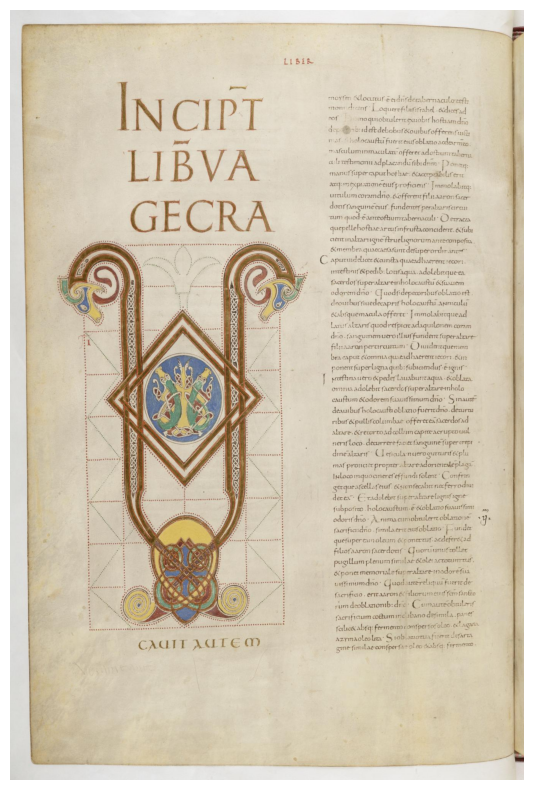

In [19]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

The prediction method of pixel-level instance segmentation

In [13]:
def adaptive_threshold(gray: np.ndarray, whs: int = 0.1, sub_threshold: float = 0.15):
  '''
  Adaptive Thresholding Binarization Algorithm Based on Integral Image
  :param gray: input gray image
  :param whs:  Sliding Window
  :param sub_threshold:
  '''
  integral_image = cv2.integral(gray, cv2.CV_32F)
  height = gray.shape[0]
  width = gray.shape[1]
  window_half_size = int(min(height, width) * whs)
  binary = np.zeros((height, width), dtype=np.uint8)
  for j in range(height):
      for i in range(width):
          x1 = i - window_half_size
          x2 = i + window_half_size
          y1 = j - window_half_size
          y2 = j + window_half_size
          x1 = 0 if x1 < 0 else x1
          y1 = 0 if y1 < 0 else y1
          x2 = width - 1 if x2 > width else x2
          y2 = height - 1 if y2 > height else y2
          count = (x2 - x1) * (y2 - y1)
          summed = integral_image[y2, x2] - integral_image[y1, x2] - integral_image[y2, x1] + integral_image[y1, x1]
          binary[j, i] = 0 if int(gray[j, i] * count) < int(summed * (1.0 - sub_threshold)) else 255
  return binary

In [14]:
def tackle_one_image(image_path, save_path):
    img = cv2.imread(image_path)
    output = predictor(img)["instances"]
    '''cv2 bin'''
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_img1 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 5)
    binary_img2 = adaptive_threshold(img_gray)
    binary_img1 = cv2.bitwise_not(binary_img1)
    binary_img2 = cv2.bitwise_not(binary_img2)
    binary_img = cv2.bitwise_and(binary_img1, binary_img2, dst=None, mask=None)
    binary_array = np.array(binary_img)
    binary_array = binary_array == 0
    bin_positions = np.where(binary_array)

    height, width, channels = img.shape #2016/1344/3
    bg_image = Image.new("RGB", (width, height), (0,0,0)) #background

    boxes = output.pred_boxes
    scores = output.scores
    classes = output.pred_classes.tolist()
    masks = np.asarray(output.pred_masks.cpu().numpy())

    '''resorted by probability in scores: low to high'''
    sorted_index = np.argsort(scores.cpu())
    boxes_sorted = boxes[sorted_index]
    scores_sorted = scores[sorted_index]
    classes_sorted = output.pred_classes[sorted_index].tolist()
    masks_sorted = masks[sorted_index]

    for box, score, class_idx, mask in zip(boxes_sorted, scores_sorted, classes_sorted, masks_sorted):
        if score < 0.20:
            continue
        if class_idx != 2:
            continue
        true_positions = np.where(mask)
        for x, y in zip(true_positions[0], true_positions[1]):
            bg_image.putpixel((y, x), color_types[class_idx])

    for box, score, class_idx, mask in zip(boxes_sorted, scores_sorted, classes_sorted, masks_sorted):
        if score < 0.20:
            continue
        if class_idx == 2:
            continue
        true_positions = np.where(mask)
        for x, y in zip(true_positions[0], true_positions[1]):
            bg_image.putpixel((y, x), color_types[class_idx])

    for x, y in zip(bin_positions[0], bin_positions[1]):
        bg_image.putpixel((y, x), (0,0,0))


    bg_image.save(save_path)

Get and show result

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


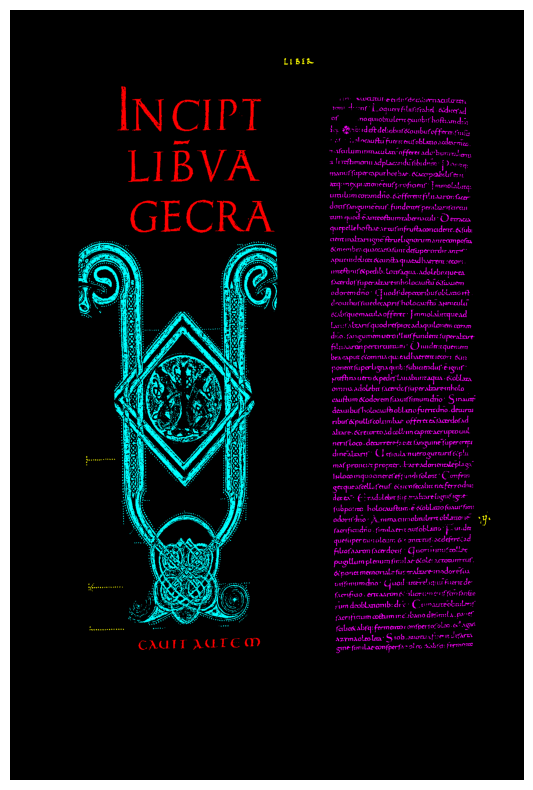

In [20]:
tackle_one_image(image_path, output_path)
pred_image = cv2.imread(output_path)
pred_image_rgb = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(pred_image_rgb)
plt.axis('off')
plt.show()

P.S.In your `evaluation_code.py`, we consider that the vars: `gt_images` and `result_images` should **in** the function `udiads_evaluate` **not** outside, so we calculate metrics by following code,

In [ ]:
"""
@author: Silvia Zottin
Evaluation code for SAM 2024: few and many shot segmentation ICDAR 2024 competition.

"""

from skimage import io
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import os
import os.path
import numpy as np

# gt_images = []
# result_images = []

def udiads_evaluate(result_directory, gt_directory):
    """
    Evaluate the results provided by the files in result_directory with respect
    to the ground truth information given by the files in gt_directory.
    """
    gt_images = []
    result_images = []
    # Check whether result_directory and gt_directory are directories
    if not os.path.isdir(result_directory):
        print("The result folder is not a directory")
        return

    if not os.path.isdir(gt_directory):
        print("The gt folder is not a directory")
        return

    # For each file of the ground truth directory read the result
    for f in sorted(os.listdir(gt_directory)):
        gt_image_path = os.path.join(gt_directory, f)
        gt_image_path = os.path.splitext(gt_image_path)[0] + ".png"
        gt_image = io.imread(gt_image_path)
        gt_images.append(gt_image.flatten())

        result_image_path = os.path.join(result_directory, f)
        result_image_path = os.path.splitext(result_image_path)[0] + ".png"
        result_image = io.imread(result_image_path)
        result_images.append(result_image.flatten())

    print(f"############## {DS} Scores ##############")
    precision = precision_score(np.array(gt_images).flatten(), np.array(result_images).flatten(), average="macro")
    recall = recall_score(np.array(gt_images).flatten(), np.array(result_images).flatten(), average="macro")
    f1_sc = f1_score(np.array(gt_images).flatten(), np.array(result_images).flatten(), average="macro")
    iou_sc = jaccard_score(np.array(gt_images).flatten(), np.array(result_images).flatten(), average="macro")

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 score: ", f1_sc)
    print("Intersection Over Union: ", iou_sc)
    return iou_sc

result = []
for DS in ["Latin2FS", "Latin14396FS", "Latin16746FS", "Syr341FS"]:

    res = udiads_evaluate(result_directory=f"{DS}/result", gt_directory=f"{DS}/gt")
    result.append(res)

print(f"############## Final Scores ##############")
print("Final result of Intersection Over Union: ", np.mean(result))